In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

In [23]:
dataframe = pd.read_csv("./heart.csv")
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [24]:
dataframe["target"] = dataframe["target"].replace(0, -1)
dataframe.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
205,42,1,3,148,244,0,0,178,0,0.8,2,2,2,1
558,39,0,2,94,199,0,1,179,0,0.0,2,0,2,1
858,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1
871,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1
276,57,1,0,132,207,0,1,168,1,0.0,2,0,3,1


In [26]:
def train_test_split(features, labels, test_size = 0.25, random_state = np.random.randint(100)):
    train_size = int(np.round((1 - test_size) * features.shape[0]))
    np.random.seed(random_state)
    new_features = np.random.permutation(features)
    np.random.seed(random_state)
    new_labels = np.random.permutation(labels)
    
    features_train = new_features[:train_size]
    labels_train = new_labels[:train_size]
    features_test = new_features[train_size:]
    labels_test = new_labels[train_size:]
    
    return features_train, features_test, labels_train, labels_test
    

In [27]:
features = np.array(dataframe.drop(columns="target"))
labels = np.array(dataframe["target"])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels)

In [28]:
# Support Vector Machine classifiers by kernel which is linear.
class SVM:
    def __init__(self, c=1, learning_rate=1):
        self.cost = c
        self.learning_rate = learning_rate
    
    def fit(self, features_train, labels_train):
        
        #store info
        self.d = features_train.shape[1]
        self.n_record = features_train.shape[0]
        
        # set up features and labels
        full_one = np.ones((self.n_record, 1))
        self.features = np.append(features_train, full_one, axis=1)
        self.labels = labels_train

        # set vector of weight by d dimensions
        self.weight = np.zeros(self.d + 1)
        self.array_weight = np.empty((0, self.d+1), float)
        
        for i in range(1000):
            self.weight = self.computeWeight(self.weight, self.features, self.labels, self.n_record) # compute to get weight's value
            
            self.array_weight = np.append(self.array_weight, [self.weight], axis=0)

        
    def computeWeight(self, weight, feature_train, labels_train, n_record):
        new_weight = weight
        for i in range(n_record):
            check = labels_train[i] * (np.inner(new_weight, feature_train[i]))
            if check < 1:
                new_weight = new_weight - self.learning_rate * (new_weight - np.inner(labels_train[i], feature_train[i]))
            else:
                new_weight = new_weight - self.learning_rate * new_weight
            
        return new_weight
    
    def predict(self, feature_test):
        new_feature_test = np.append(feature_test, 1)
        check = np.inner(self.weight, new_feature_test)
        if check >= 0 :
            # positive class
            return 1 
        else:
            # negative class
            return -1
    
    def hinge_loss(self, weight, features, labels, size):
        sum_loss = 0
        for i in range(size):
            check = 1-labels[i] * (np.inner(weight, features[i]))
            if check > 0:
                sum_loss += check
        return sum_loss
    
    def accuracy_score(self, features_test, labels_test):
        size = features_test.shape[0]
        point = 0
        for i in range(size):
            y_predict = self.predict(features_test[i])
            if y_predict == labels_test[i]:
                point += 1
        
        return np.round(point / size, 4)
    
    def get_array_loss(self, features, labels):
        array_loss = np.array([])
        full_one = np.ones((features.shape[0], 1))
        new_features = np.append(features, full_one, axis=1)
        number_weight = self.array_weight.shape[0]
        number_record = features.shape[0]
        
        for i in range(number_weight):
            loss = self.hinge_loss(self.array_weight[i], new_features, labels, number_record)
            array_loss = np.append(array_loss, loss)
        
        return array_loss
    
    def sensitivity_score(self, features_test, labels_test):
        size = features_test.shape[0]
        pointTP = 0
        pointFP = 0

        for i in range(size):
            y_predict = self.predict(features_test[i])
            if y_predict == labels_test[i] and y_predict == 1:
                pointTP += 1
                
            elif y_predict == 1:
                pointFP += 1
        
        return np.round(pointTP/(pointTP + pointFP), 4)
            

In [29]:
model = SVM(learning_rate=0.0000005)
model.fit(features_train, labels_train)
print(model.weight)

[-0.02114243 -0.0394635   0.0839023  -0.01496805 -0.00448641 -0.00285777
  0.00711931  0.02883014 -0.04031837 -0.08519179  0.02439817 -0.08178893
 -0.05173901 -0.00208308]


Accuracy of Test data

In [30]:
model.accuracy_score(features_test, labels_test)

0.7109

Accuracy of Training data

In [31]:
model.accuracy_score(features_train, labels_train)

0.7321

Sensitivity of Test data

In [32]:
model.sensitivity_score(features_test, labels_test)

0.72

Sensitivity of Training data

In [33]:
model.sensitivity_score(features_train, labels_train)

0.7442

In [34]:
model.array_weight.shape

(1000, 14)

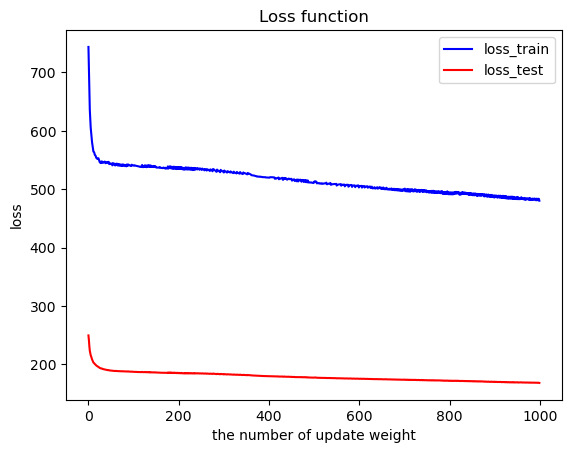

In [35]:
# plot that is loss training data
plt.plot(model.get_array_loss(features_train, labels_train), color="b", label = "loss_train")
# plot that is loss test data
plt.plot(model.get_array_loss(features_test, labels_test), color="r", label = "loss_test")
plt.ylabel("loss")
plt.xlabel("the number of update weight")
plt.title("Loss function")
plt.legend()
plt.show()

In [36]:
# Model Selection
class ModelSelection:
    def __init__(self, features, labels , model, n_split=10):
        self.features = features
        self.labels = labels
        self.model = model
        self.n_split = n_split
    